In [1]:
%load_ext autoreload

# Uniform Manifold Approximation and US

In [2]:
import os
import time
import umap
import torch
import numpy as np

from pdmtut.core import GenerativeModel
from umap.distances import minkowski_grad
from joblib import dump, load

In [3]:
store_results = True
load_models = True

## Introduction

## Implementation

In [4]:
class UMap(GenerativeModel):
    def __init__(self):
        super().__init__()
        #self.model = umap.UMAP(random_state=42, metric=minkowski_grad, metric_kwds={'p':5}, min_dist=0.)
        self.model = umap.UMAP(
            random_state=42, metric=minkowski_grad,
            metric_kwds={'p':5}, min_dist=0.99,
            n_components=2, n_neighbors=15
        )

    @property
    def n_components(self):
        return self.model.n_components

    def fit_model(self, X, path):
        start_time = time.time()
        xs = self.model.fit_transform(X)
        self.phi_min_max = xs[:,0].min(), xs[:,0].max()
        self.theta_min_max = xs[:,1].min(), xs[:,1].max()
        elapsed_time = time.time() - start_time
        
        if path is not None: 
            with open(os.path.join(path, 'training_time.txt'), 'w') as f:
                f.write(str(elapsed_time))

    def encode(self, X):
        return torch.from_numpy(self.model.transform(X))

    def decode(self, X):
        return torch.from_numpy(self.model.inverse_transform(X))
    
    def save(self, path):
        if path is not None:
            dump(self, os.path.join(path, 'model.joblib')) 
    
    def load(path):
        if path is not None:
            return load(os.path.join(path, 'model.joblib'))

    def save_exists(path):
        return os.path.isfile(os.path.join(path, 'model.joblib'))

    def log_likelihood(self, X):
        # return the log likelihood of each sample
        return torch.ones(X.shape[0])

    def sample_posterior(self, n_samples):
        z_samples = torch.stack([
            torch.FloatTensor(n_samples).uniform_(*self.phi_min_max),
            torch.FloatTensor(n_samples).uniform_(*self.theta_min_max)
        ], -1)

        return torch.from_numpy(self.model.inverse_transform(z_samples))

    def __str__(self):
        return 'umap'

## Experiment 1a: swiss roll

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/umap'

if store_results:
    result_save_path = '../results/swiss_roll/umap'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None 

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and UMap.save_exists(model_save_path):
    model = UMap.load(model_save_path)
else:
    model = UMap()
    model.fit_model(dataset.X, result_save_path)
    
    if store_results:
        model.save(model_save_path)

### Input Representation

In [8]:
from pdmtut.vis import plot_representation

In [9]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)

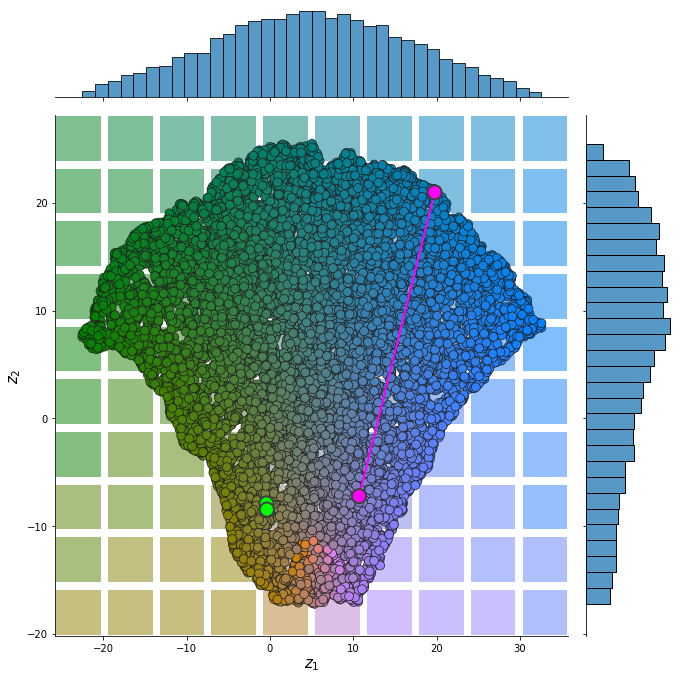

In [10]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [11]:
from pdmtut.vis import plot_reconstruction

In [12]:
z = model.encode(dataset.X)
x = model.decode(z)

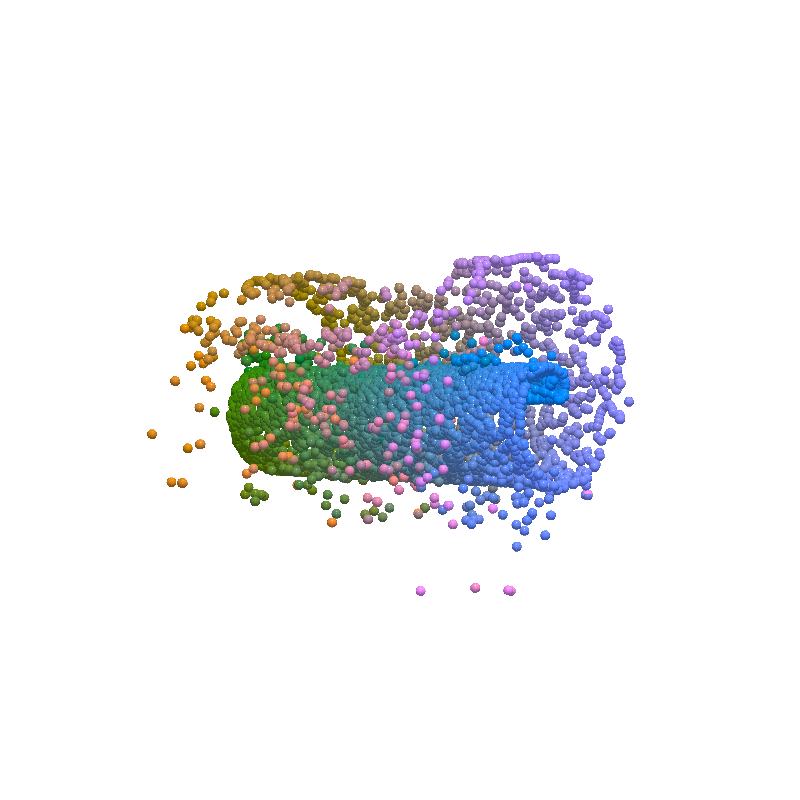

In [13]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

### Density Estimation

In [14]:
from pdmtut.vis import plot_density

In [15]:
log_likelihood = model.log_likelihood(dataset.X)

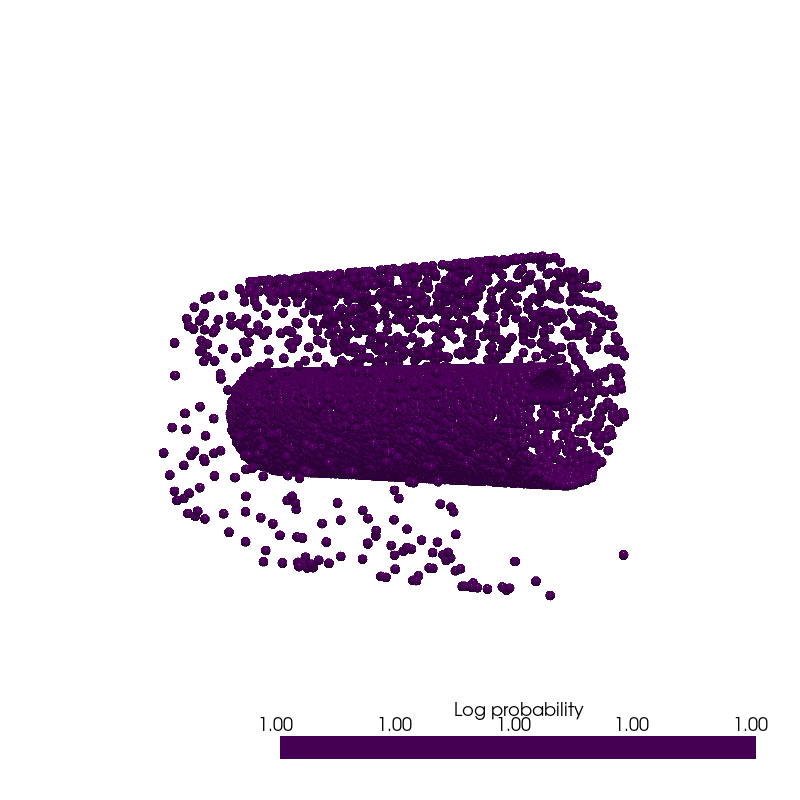

In [16]:
plot_density(dataset.unnormalise_scale(dataset.X).numpy(), log_likelihood.numpy(), root=result_save_path)

### Generate Samples

In [17]:
from pdmtut.vis import plot_generated_samples

In [18]:
generated_samples = model.sample_posterior(100**2)
generated_samples_log_likelihood = model.log_likelihood(generated_samples)

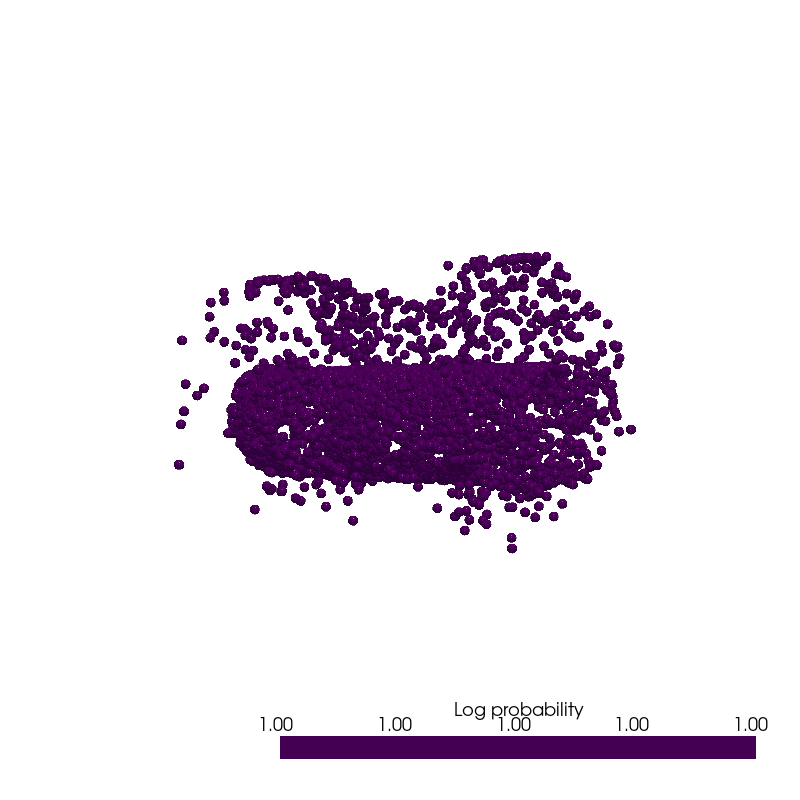

In [19]:
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy(), root=result_save_path)

### Interpolation

In [20]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [21]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))

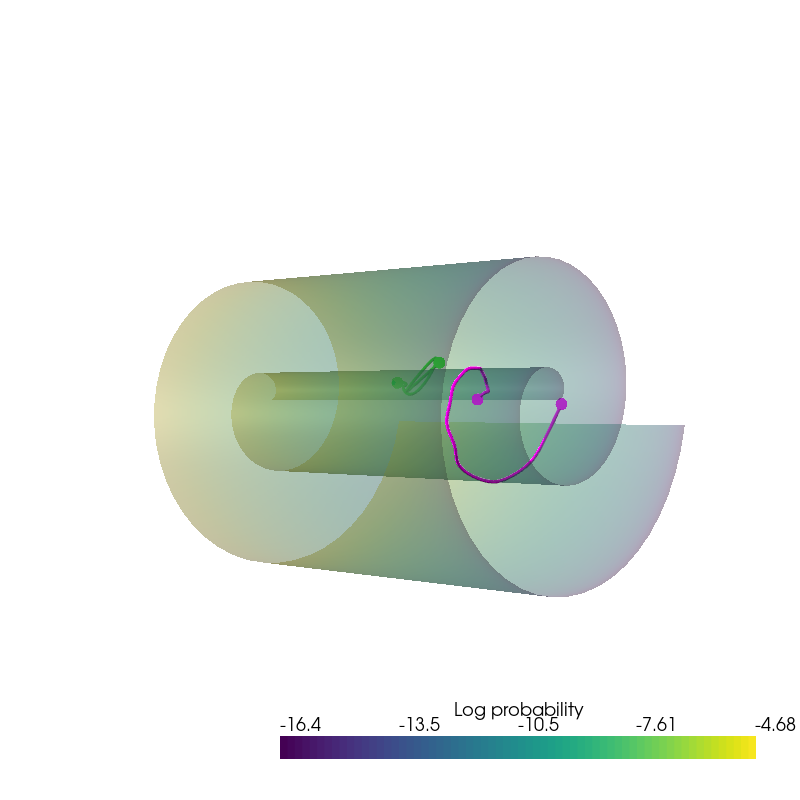

In [22]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)